# Manual DCF Projection for NOVO-B.CO
This notebook replicates the calculations of the program series for NOVO-B.CO, allowing manual input of growth rate projections.

In [30]:
# Import Required Libraries
import pandas as pd
import numpy as np
import yfinance as yf

In [31]:
# Manually Input Growth Rate Projection
from IPython.display import display

growth_rate = 0.05
projection_years = 5
discount_rate = 0.07297414213597408

display({'Growth Rate': growth_rate, 'Projection Years': projection_years, 'Discount Rate': discount_rate})

{'Growth Rate': 0.05,
 'Projection Years': 5,
 'Discount Rate': 0.07297414213597408}

In [32]:
# Fetch Financial Statements for NOVO-B.CO
ticker = 'NOVO-B.CO'
t = yf.Ticker(ticker)

# Get TTM and latest annual data
income = t.financials
cashflow = t.cashflow
balance = t.balance_sheet

ttm_income = t.ttm_financials
ttm_cashflow = t.ttm_cashflow
quarterly_balance = t.quarterly_balancesheet



In [33]:
# Calculate Free Cash Flow to Firm (FCFF)
def calculate_fcff(row):
    ebit = row.get('EBITDA', np.nan)
    depreciation = row.get('Depreciation & Amortization', np.nan)
    capex = row.get('Capital Expenditure', np.nan)
    delta_wc = row.get('Change In Working Capital', np.nan)
    tax_provision = row.get('Tax Provision', np.nan)
    pretax_income = row.get('Pretax Income', np.nan)
    # Estimate effective tax rate
    if pd.notna(tax_provision) and pd.notna(pretax_income) and pretax_income != 0:
        tax_rate = tax_provision / pretax_income
        if not (0 <= tax_rate <= 1):
            tax_rate = 0.25
    else:
        tax_rate = 0.25
    if pd.isna(ebit):
        ebit = row.get('Net Income', np.nan)  # fallback
    if pd.isna(depreciation):
        depreciation = 0
    if pd.isna(capex):
        capex = 0
    if pd.isna(delta_wc):
        delta_wc = 0
    fcff = ebit * (1 - tax_rate) + depreciation - capex - delta_wc
    return fcff

# Try to get TTM values for calculation
fcff_ttm = None
if ttm_income is not None and ttm_cashflow is not None:
    ttm_row = {
        'EBITDA': ttm_income.loc['EBITDA'].iloc[0] if 'EBITDA' in ttm_income.index else np.nan,
        'Depreciation & Amortization': ttm_cashflow.loc['Depreciation And Amortization'].iloc[0] if 'Depreciation And Amortization' in ttm_cashflow.index else 0,
        'Capital Expenditure': ttm_cashflow.loc['Capital Expenditure'].iloc[0] if 'Capital Expenditure' in ttm_cashflow.index else 0,
        'Change In Working Capital': ttm_cashflow.loc['Change In Working Capital'].iloc[0] if 'Change In Working Capital' in ttm_cashflow.index else 0,
        'Tax Provision': ttm_income.loc['Tax Provision'].iloc[0] if 'Tax Provision' in ttm_income.index else np.nan,
        'Pretax Income': ttm_income.loc['Pretax Income'].iloc[0] if 'Pretax Income' in ttm_income.index else np.nan,
        'Net Income': ttm_income.loc['Net Income'].iloc[0] if 'Net Income' in ttm_income.index else np.nan
    }
    fcff_ttm = calculate_fcff(ttm_row)
    print(f"FCFF (TTM): {fcff_ttm:,.0f}")
else:
    print("TTM data not available.")

FCFF (TTM): 201,012,916,361


In [34]:
# Calculate Free Cash Flow to Equity (FCFE)
def calculate_fcfe(fcff, change_in_debt):
    if pd.isna(change_in_debt):
        change_in_debt = 0
    return fcff + change_in_debt

# Try to get TTM change in debt
change_in_debt_ttm = None
if quarterly_balance is not None and 'Total Debt' in quarterly_balance.index:
    debt_series = quarterly_balance.loc['Total Debt']
    debt_series = debt_series.dropna()
    if len(debt_series) >= 5:
        latest = debt_series.iloc[0]
        prev_year = debt_series.iloc[4]
        change_in_debt_ttm = latest - prev_year
    else:
        change_in_debt_ttm = np.nan
else:
    change_in_debt_ttm = np.nan

fcfe_ttm = calculate_fcfe(fcff_ttm, change_in_debt_ttm)
print(f"FCFE (TTM): {fcfe_ttm:,.0f}")

FCFE (TTM): 292,807,916,361


In [35]:
# Apply Growth Rate Projection to FCFF
projected_fcff = []
if fcff_ttm is not None and not pd.isna(fcff_ttm):
    last_fcff = fcff_ttm
    for year in range(1, projection_years + 1):
        next_fcff = last_fcff * (1 + growth_rate)
        projected_fcff.append(next_fcff)
        last_fcff = next_fcff
else:
    print("Cannot project FCFF: TTM FCFF not available.")

# Discount projected FCFFs to present value
discount_factors = [1 / ((1 + discount_rate) ** (i + 1)) for i in range(projection_years)]
present_values = [fcff * df for fcff, df in zip(projected_fcff, discount_factors)]

# Calculate total present value
dcf_value = sum(present_values)

print(discount_rate)
print("Projected FCFFs:", projected_fcff)
print("Discount Factors:", discount_factors)
print("Present Values:", present_values)
print(f"Total DCF Value (sum of PVs): {dcf_value:,.0f}")

0.07297414213597408
Projected FCFFs: [211063562178.58603, 221616740287.51535, 232697577301.8911, 244332456166.9857, 256549078975.335]
Discount Factors: [0.9319889088932711, 0.86860332630007, 0.8095286663394683, 0.754471738459546, 0.7031592923177217]
Present Values: [196708899021.94748, 192497037777.51456, 188375359413.62524, 184341932966.3965, 180394868817.05984]
Total DCF Value (sum of PVs): 942,318,097,997


In [37]:
2025,211063562178.58603,0.05,196708899021.94748,0.9319889088932711,Projected calendar year
2026,221616740287.51535,0.05,192497037777.51456,0.86860332630007,Projected calendar year
2027,232697577301.8911,0.05,188375359413.62524,0.8095286663394683,Projected calendar year
2028,244332456166.9857,0.05,184341932966.3965,0.754471738459546,Projected calendar year
2029,256549078975.335,0.05,180394868817.05984,0.7031592923177217,Projected calendar year
,4939769668816.176,0.02,3473444944537.3286,0.7031592923177217,Terminal value

SyntaxError: invalid syntax (852548917.py, line 1)

,FCFF,FCFE,Present Value
TTM,2.010129e+11,2.928079e+11,NaN
Year 1,2.110636e+11,NaN,1.972557e+11
Year 2,2.216167e+11,NaN,1.935686e+11
Year 3,2.326976e+11,NaN,1.899505e+11
Year 4,2.443325e+11,NaN,1.864001e+11
Year 5,2.565491e+11,NaN,1.829159e+11


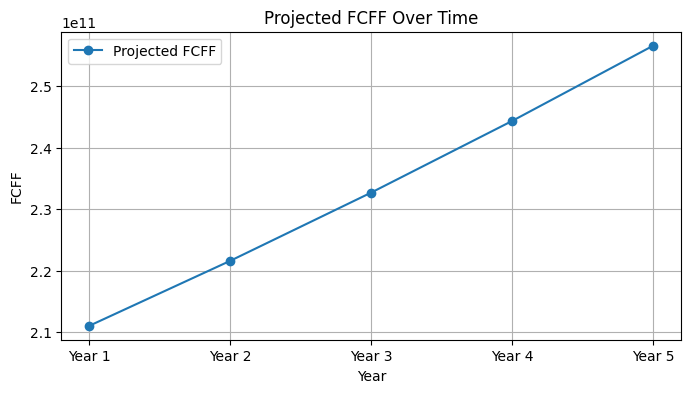

In [ ]:
# Display Projected Cash Flows
years = ['TTM'] + [f'Year {i}' for i in range(1, projection_years + 1)]
fcff_list = [fcff_ttm] + projected_fcff
fcfe_list = [fcfe_ttm] + [np.nan] * projection_years
present_value_list = [np.nan] + present_values

results_df = pd.DataFrame({
    'FCFF': fcff_list,
    'FCFE': fcfe_list,
    'Present Value': present_value_list
}, index=years)

display(results_df)

import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(results_df.index[1:], results_df['FCFF'][1:], marker='o', label='Projected FCFF')
plt.title('Projected FCFF Over Time')
plt.ylabel('FCFF')
plt.xlabel('Year')
plt.legend()
plt.grid(True)
plt.show()

In [50]:
# Calculate Terminal Value, Add Cash, Subtract Debt, and Compute Intrinsic Value per Share

# Terminal value using perpetuity growth model (Gordon Growth)
terminal_growth_rate = 0.02  # You can adjust this as needed
tv_year = projection_years
last_projected_fcff = projected_fcff[-1] if projected_fcff else 0
terminal_value = last_projected_fcff * (1 + terminal_growth_rate) / (discount_rate - terminal_growth_rate)
terminal_value_pv = terminal_value / ((1 + discount_rate) ** tv_year)

# Sum of present values of projected FCFFs + terminal value
enterprise_value = dcf_value + terminal_value_pv

# Get latest cash and debt from balance sheet
total_cash = np.nan
total_debt = np.nan
shares_outstanding = np.nan
try:
    if balance is not None:
        if 'Cash' in balance.index:
            total_cash = balance.loc['Cash'].iloc[0]
        if 'Total Debt' in balance.index:
            total_debt = balance.loc['Total Debt'].iloc[0]
    info = t.info
    shares_outstanding = info.get('sharesOutstanding', np.nan)
except Exception as e:
    print('Error fetching cash, debt, or shares:', e)

# Calculate equity value and intrinsic value per share
equity_value = enterprise_value - balance.loc['Net Debt'].iloc[0] 
intrinsic_value_per_share = equity_value / shares_outstanding if shares_outstanding and not pd.isna(shares_outstanding) else np.nan

print(f"\nTerminal Value (at year {tv_year}): {terminal_value:,.0f}")
print(f"Present Value of Terminal Value: {terminal_value_pv:,.0f}")
print(f"Enterprise Value (DCF + TV): {enterprise_value:,.0f}")
print(f"Cash: {total_cash:,.0f} | Debt: {total_debt:,.0f}")
print(f"Equity Value: {equity_value:,.0f}")
print(f"Shares Outstanding: {shares_outstanding:,.0f}")
print(f"Intrinsic Value per Share: {intrinsic_value_per_share:,.2f}")


Terminal Value (at year 5): 4,939,769,668,816
Present Value of Terminal Value: 3,473,444,944,537
Enterprise Value (DCF + TV): 4,415,763,042,534
Cash: nan | Debt: 102,787,000,000
Equity Value: 4,335,397,042,534
Shares Outstanding: 3,368,499,968
Intrinsic Value per Share: 1,287.04


In [39]:
last_projected_fcff * (1 + terminal_growth_rate) / (discount_rate - terminal_growth_rate)

4939769668816.176

In [ ]:
last_proj_fcf * (1 + terminal_growth) / (wacc - terminal_growth)
np.float64(7784834882755.664)
last_proj_fcf
np.float64(404308774102.1448)
terminal_growth
0.02
wacc
np.float64(0.07297414213597408)

In [40]:
last_projected_fcff

256549078975.335

In [ ]:
terminal_val
np.float64(4939769668816.176)

In [ ]:
last_proj_fcf
np.float64(256549078975.335)

In [52]:
terminal_value / ((1 + discount_rate) ** tv_year)


3473444944537.3286

In [45]:
1/((1 + discount_rate) ** tv_year)

0.7031592923177217

In [43]:

# Sum of present values of projected FCFFs + terminal value
dcf_value + terminal_value_pv

4622373421864.564

In [51]:
terminal_value

4939769668816.176

In [48]:
last_projected_fcff * (1 + terminal_growth_rate) / (discount_rate - terminal_growth_rate)

4939769668816.176

In [53]:
dcf_value

942318097996.5437

In [54]:
present_values

[196708899021.94748,
 192497037777.51456,
 188375359413.62524,
 184341932966.3965,
 180394868817.05984]

In [ ]:
terminal_discount_factor
np.float64(0.7031592923177217)
terminal_val
np.float64(4939769668816.176)
terminal_val * terminal_discount_factor
np.float64(3473444944537.3286)

In [ ]:
pv_vals
0    2.154431e+11
1    2.309091e+11
2    2.474855e+11
3    2.652518e+11
4    2.842935e+11
Name: FCFF, dtype: float64
pv_vals.sum()
np.float64(1243382950064.148)

In [ ]:
{
  "enterprise_value": 942318097996.5436,
  "sum_pv": 942318097996.5436,
  "terminal_value": 4939769668816.176,
  "npv": 942318097996.5436,
  "net_debt": 79785000000.0,
  "equity_value": 862533097996.5436,
  "per_share_value": 256.0585145288455,
  "upside": -42.00260146572016,
  "average_growth_rate": 0.050000000000000044
}

In [ ]:
balance.loc[['Net Debt', 'Total Debt', 'Cash And Cash Equivalents', 'Cash Financial']]

,2024-12-31,2023-12-31,2022-12-31,2021-12-31,2020-12-31
Net Debt,80366000000.0,6888000000.0,8602000000.0,11796000000.0,NaN
Total Debt,102787000000.0,27006000000.0,25784000000.0,26645000000.0,NaN
Cash And Cash Equivalents,15655000000.0,14392000000.0,12653000000.0,10720000000.0,NaN
Cash Financial,15655000000.0,14392000000.0,12653000000.0,10720000000.0,NaN


In [ ]:
102787000000.0-15655000000.0

87132000000.0

In [ ]:
balance.index

Index(['Treasury Shares Number', 'Ordinary Shares Number', 'Share Issued',
       'Net Debt', 'Total Debt', 'Tangible Book Value', 'Invested Capital',
       'Working Capital', 'Net Tangible Assets', 'Capital Lease Obligations',
       'Common Stock Equity', 'Total Capitalization',
       'Total Equity Gross Minority Interest', 'Stockholders Equity',
       'Gains Losses Not Affecting Retained Earnings',
       'Other Equity Adjustments', 'Treasury Stock', 'Retained Earnings',
       'Capital Stock', 'Common Stock',
       'Total Liabilities Net Minority Interest',
       'Total Non Current Liabilities Net Minority Interest',
       'Other Non Current Liabilities', 'Employee Benefits',
       'Non Current Pension And Other Postretirement Benefit Plans',
       'Non Current Deferred Liabilities',
       'Non Current Deferred Taxes Liabilities',
       'Long Term Debt And Capital Lease Obligation',
       'Long Term Capital Lease Obligation', 'Long Term Debt',
       'Long Term Provision